### A series of attempts to answer Google-able questions with the power of python. 
II. Explore additional potential correlations with crime rate : employment rate, poverty index, number of police per capita,     

Resources used include Uniform Crime Reporting Statistics - UCR Data Online, which produces CSV files based on variety of user-specified parameters:
http://www.ucrdatatool.gov/

Note: UCR provides this caution against drawing broad conclusions based on limited selection
of data to investigate here http://www.ucrdatatool.gov/ranking.cfm

Also note:  Rates are the number of reported offenses per 100,000 population by UCR

##  2.III Understand similarities in outlier population

In [1]:
#!/usr/bin/env python
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import math
%matplotlib inline

In [2]:
# Columns in CSV crime files from UCR are the following: 
cols = ['Year','Population','Violent crime total','Murder and nonnegligent Manslaughter',\
    'Forcible rape','Robbery','Aggravated assault','Property crime total','Burglary','Larceny-theft','Motor vehicle theft',\
    'Violent Crime rate','Murder and nonnegligent manslaughter rate','Forcible rape rate','Robbery rate',\
    'Aggravated assault rate','Property crime rate','Burglary rate','Larceny-theft rate','Motor vehicle theft rate']

# Compile list of most dangerous cities from here: 
# http://www.worldatlas.com/articles/most-dangerous-cities-in-the-united-states.html
# and get the corresponding areas from Google
cities = [ 'DetroitPD', 'MemphisPD', 'OaklandPD', 'StLouisPD', 'MilwaukeePD', 'BaltimorePD', 'Cleveland', 'Stockton',\
           'Indianapolis', 'KansasCity', 'BuffaloPD', 'AtlantaPD', 'DC', 'NashvillePD', 'Toledo', 'NewarkPD', 'MiamiPD',\
           'PhiladelphiaPD', 'MinneapolisPD', 'HoustonPD', 'NewOrleansPD', 'Cincinnati', 'OrlandoPD', 'ChicagoPD', \
           'AlbuquerquePD', 'StPetersburgPD', 'AnchoragePD', 'LasVegasPD', 'TulsaPD', 'Pittsburgh' ]

# Footage in square miles-- Note: LasVegas is 135.9 sq miles, but the data from UCR
# is for Las Vegas Metropolitan area, which is 600 sq miles 
sq_foot = [ 142.9, 324., 78., 65.98, 96.8, 92.28, 82.47, 62.1, 372., 319., 52.51, 132.4, 68.34, 526., 84.12, 26.11, 55.25,\
          141.7, 58.42, 627., 350., 79.54, 110.7, 234., 189.5, 137.6, 1969., 600., 196.8, 58.3]

# Use google to find unemployment rates for each city, in fractions
# These are rates from the end of 2012 (to align with the data from UCR)
#, https://ycharts.com/indicators/
unemp_rate = [.17,.082,0.096,0.081,.097,0.098,0.068,.137,0.094,0.085,0.099,0.095,0.087,0.062,0.081,.132,0.08,\
              .105,0.047,0.06,0.071,0.077,0.071,0.095,0.066,0.071,0.058,0.085,0.053,0.071]

In [3]:
# Get all csv files into a list for convenient access
crime_data = []
crime_rate = []

for i in xrange(len(cities)):
    data_i = pd.read_csv("Cities/%sCrimeStats.csv" % cities[i])
    df_i = pd.DataFrame(data_i,columns=cols)
    crime_data.append(df_i)
    
    last_el = crime_data[i]['Year'].shape[0] - 1    
    crime_rate.append(crime_data[i]['Murder and nonnegligent manslaughter rate'][last_el])
    
pop_dens = [ crime_data[i]['Population'][crime_data[i]['Population'].shape[0]-1]\
            /sq_foot[i]/1000 for i in xrange(len(sq_foot))]

In [8]:
#http://statsmodels.sourceforge.net/
# Perform an ordinary least squares fit + evaluate influence of points to exclude outliers
import statsmodels.api as sm

UR_fit = sm.add_constant(unemp_rate)
model = sm.OLS(crime_rate,UR_fit).fit()

influ_v = model.get_influence()
influ_s = influ_v.summary_frame()['student_resid']
outliers = influ_s.ix[abs(influ_s) > 1.] # 0.1 Chosen visually

282.116192254 -7.56868680977


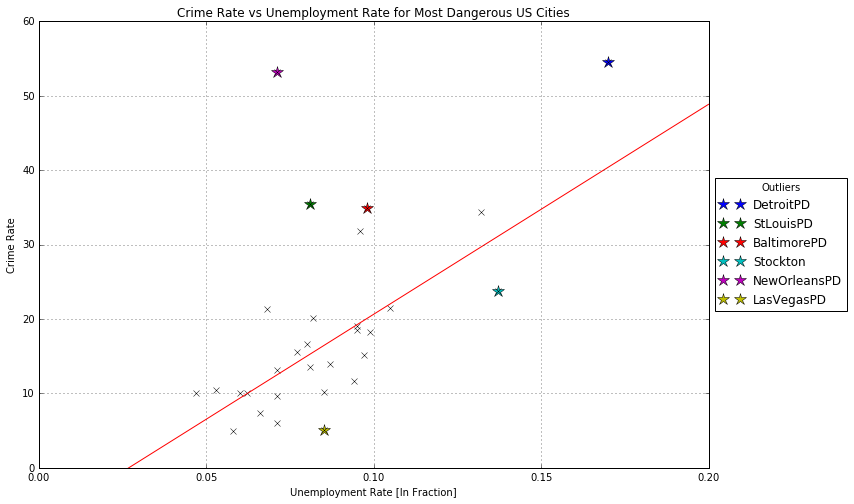

In [10]:
plt.figure(figsize=(12,8))

cr_plot = []
pd_plot = []
for i in xrange(len(cities)):
    last_el = crime_data[i]['Year'].shape[0] - 1    
    if i not in outliers:
        cr_plot.append(crime_data[i]['Murder and nonnegligent manslaughter rate'][last_el])
        pd_plot.append(unemp_rate[i])
    else:
        plt.plot(float(unemp_rate[i]),crime_rate[i],'*',label=cities[i],ms=12)    
    
    plt.plot(float(unemp_rate[i]),crime_rate[i],'kx')
    
# This fit neglects points I've visually decided are outliers
fitx = np.linspace(0,.2,100)
m,b = np.polyfit(pd_plot, cr_plot,1)
print m, b

plt.plot(fitx,m*fitx+b,'r-')
plt.ylabel("Crime Rate")
plt.xlabel("Unemployment Rate [In Fraction]")
plt.title("Crime Rate vs Unemployment Rate for Most Dangerous US Cities")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),title='Outliers')
plt.grid(True)
plt.ylim(0,60)
plt.show()

Would need more data points (and or a higher dimensional analysis that took multiple variables into account) to understand what kind of fit describes the relationship between CR and UR. From what I have here, it looks like a linear polynomial under-fits the data; perhaps there is a gaussian spread across the 2 variables better explains the relationship.